### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from numpy import mean
from numpy import std
import statsmodels.api as sm
import math
from scipy import stats
from statsmodels.stats import weightstats as stests
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
df_original = pd.read_csv("predicting_carbon_emissions.csv")
df = df_original.copy()

### Cleaning

In [3]:
pd.set_option('display.max_columns', None)
df.columns = df.columns.str.strip().str.replace(' ', '_')
df.columns = df.columns.str.strip().str.replace('(', '').str.replace(')', '')
df = df.rename(columns = {'Carbon_Emission__tCO2e/mmUSD':'Carbon'})

In [4]:
#drop columns
columns_to_drop = ['Ticker', 'ISIN','Account_ID']
df.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
# Dropping the Company Names with incomplete Carbon Info
df = df[df["Company_Name"] != 'Kathmandu Holdings']
df = df[df["Company_Name"] != 'Stephenson Harwood']
df = df[df["Company_Name"] != 'Nordic Semiconductor ASA']

#### Creating Reported Scope Columns (can be changed into classes) and Revenue Column

In [6]:
#change values in Reported Scope 1 column to not have , or -, then change to floats. replace null values with 0
df["Reported_Scope_1_tCO2e"] = df["Reported_Scope_1_tCO2e"].str.strip().str.replace(',', '').str.replace('-','0').astype(float)
df["Reported_Scope_1_tCO2e"].fillna(0,inplace=True)

In [7]:
#change values in Estimated Scope 1 column to not have , or -, then change to floats. replace null values with 0
df["Estimated_Scope_1_tCO2e"] = df["Estimated_Scope_1_tCO2e"].astype(str).str.strip().str.replace(',', '').str.replace('-','0').astype(float)
df["Estimated_Scope_1_tCO2e"].fillna(0,inplace=True)

In [8]:
#create column for scope
df['Scope_1_tCO2e'] = df["Reported_Scope_1_tCO2e"]+df["Estimated_Scope_1_tCO2e"]

In [9]:
#change values in Reported Scope 1 column to not have , or -, then change to floats. replace null values with 0
df["Reported_location-based_Scope_2_tCO2e"] = df["Reported_location-based_Scope_2_tCO2e"].str.strip().str.replace(',', '').str.replace('-','0').astype(float)
df["Reported_location-based_Scope_2_tCO2e"].fillna(0,inplace=True)

In [10]:
#change values in Estimated Scope 1 column to not have , or -, then change to floats. replace null values with 0
df["Estimated_location-based_Scope_2_tCO2e"] = df["Estimated_location-based_Scope_2_tCO2e"].astype(str).str.strip().str.replace(',', '').str.replace('-','0').astype(float)
df["Estimated_location-based_Scope_2_tCO2e"].fillna(0,inplace=True)

In [11]:
#create column for scope
df['Scope_2_tCO2e'] = df["Reported_location-based_Scope_2_tCO2e"]+df["Estimated_location-based_Scope_2_tCO2e"]

In [12]:
df['Scope_1_and_2_tCO2e'] = df["Scope_1_tCO2e"]+df["Scope_2_tCO2e"]

In [13]:
df.drop(df[df["Carbon"]==0].index, inplace = True)

In [14]:
df["Revenue"] = round((df['Scope_1_and_2_tCO2e'])/(df["Carbon"]),3)

#### Creating Dummy Columns with Binary of GICS Sectors

In [15]:
df = pd.concat([df,pd.get_dummies(df['GICS_Sector'])], axis=1)
df.columns = df.columns.str.strip().str.replace(' ', '_')

#### Removing Agencia de Proteccion Ambiental due to Nulls

In [16]:
df.drop(df.index[0],inplace=True)

In [17]:
df = df.dropna(subset=['Scope_2_figure_used_for_intensity'], how='any')

In [18]:
df = df.dropna(subset = ['Location-based_Scope_2_source','Scope_1_source']).reset_index(drop=True)

In [19]:
for i, row in df.iterrows():
    if ("Estimated" in row["Scope_1_source"]) and ("Estimated" in row["Location-based_Scope_2_source"]):
        df.loc[i,'Estimated_or_not'] = "Estimated"
    elif ("Reported" in row["Scope_1_source"]) and ("Reported" in row["Location-based_Scope_2_source"]):
        df.loc[i,'Estimated_or_not'] = "Reported"
    else:
        df.loc[i,'Estimated_or_not'] = "Mixed"

In [20]:
df['Estimated_or_not'].value_counts()

Reported     2331
Estimated    1398
Mixed         138
Name: Estimated_or_not, dtype: int64

In [21]:
# df.to_csv("data_cleaned.csv")

### Hypothesis 1 - Do Greenhouse Gas Emissions vary by industry sector?

/Users/ahilan/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



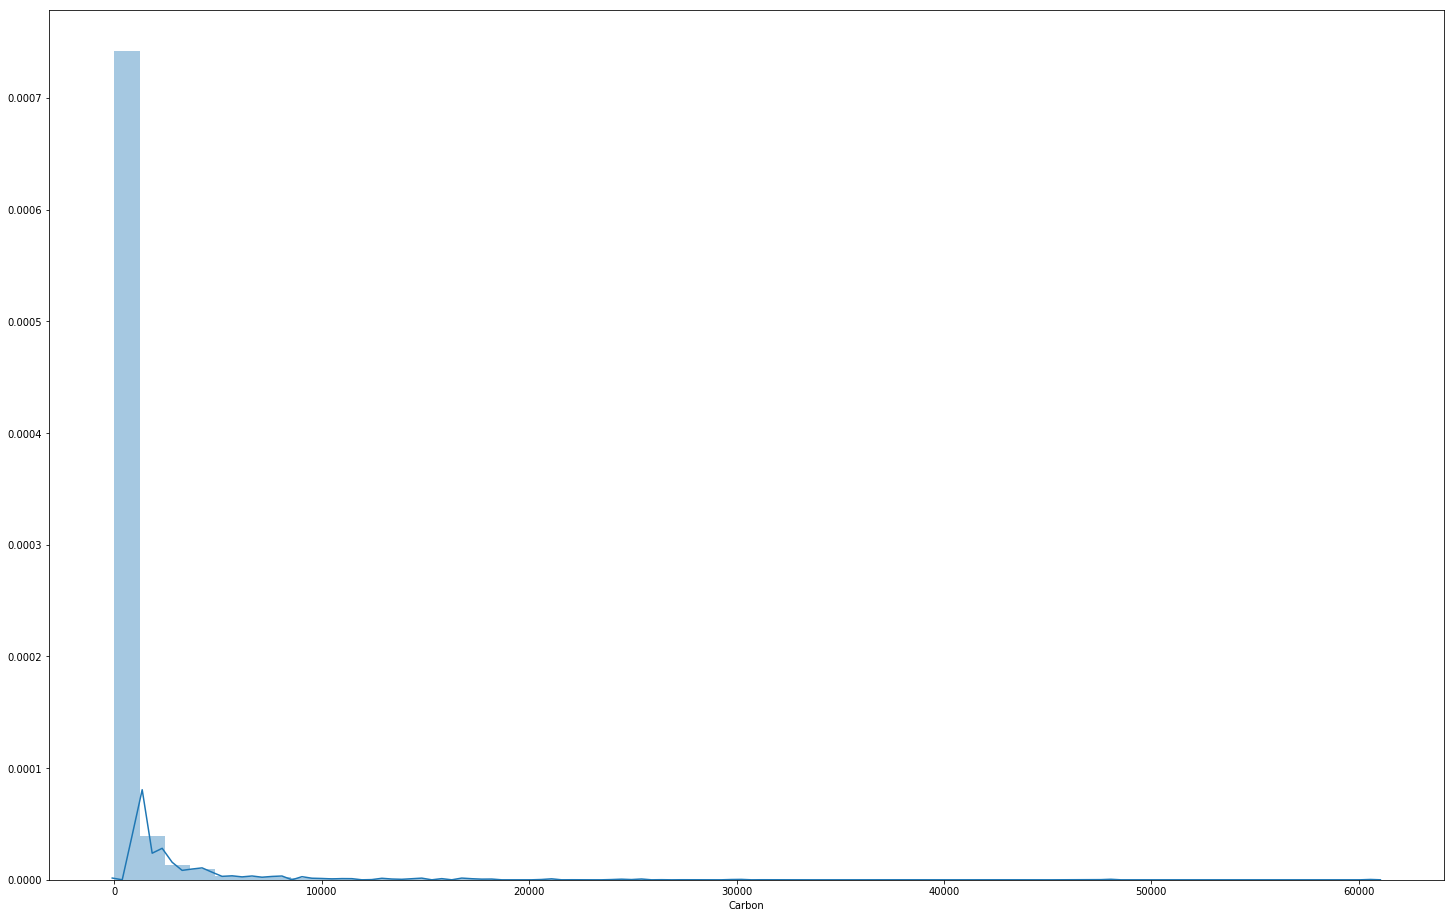

In [22]:
plt.figure(figsize=(25,16))
sns.distplot(df['Carbon'])

/Users/ahilan/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



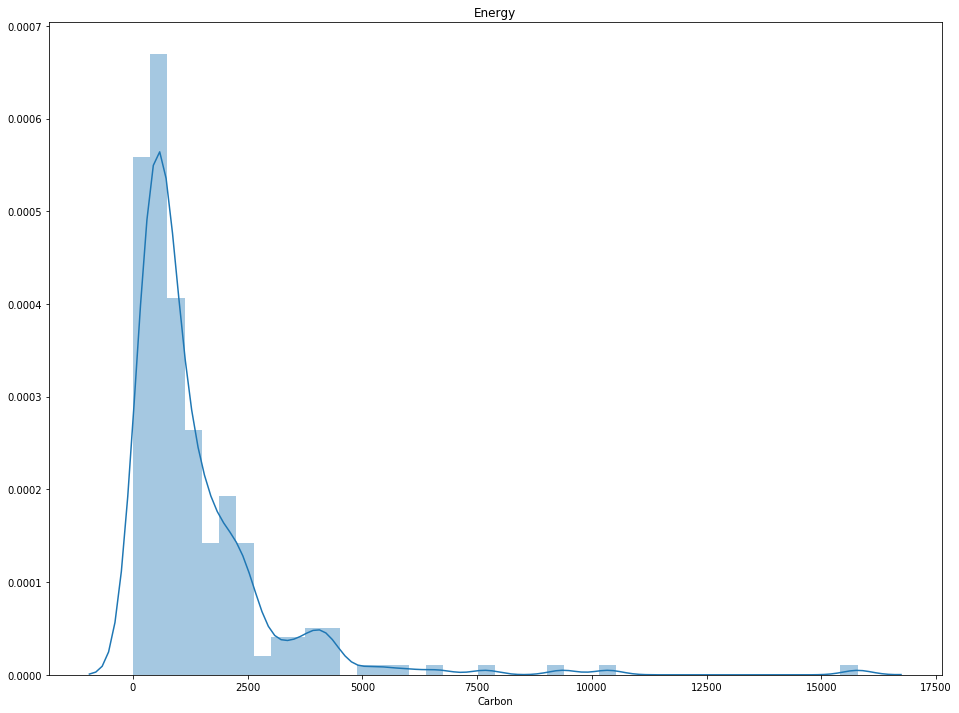

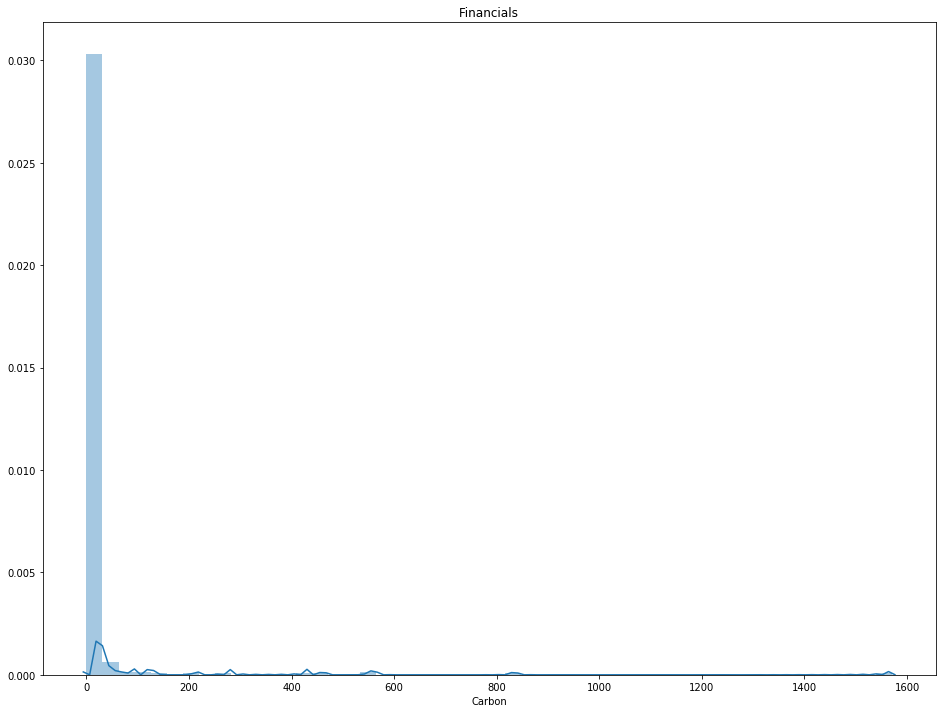

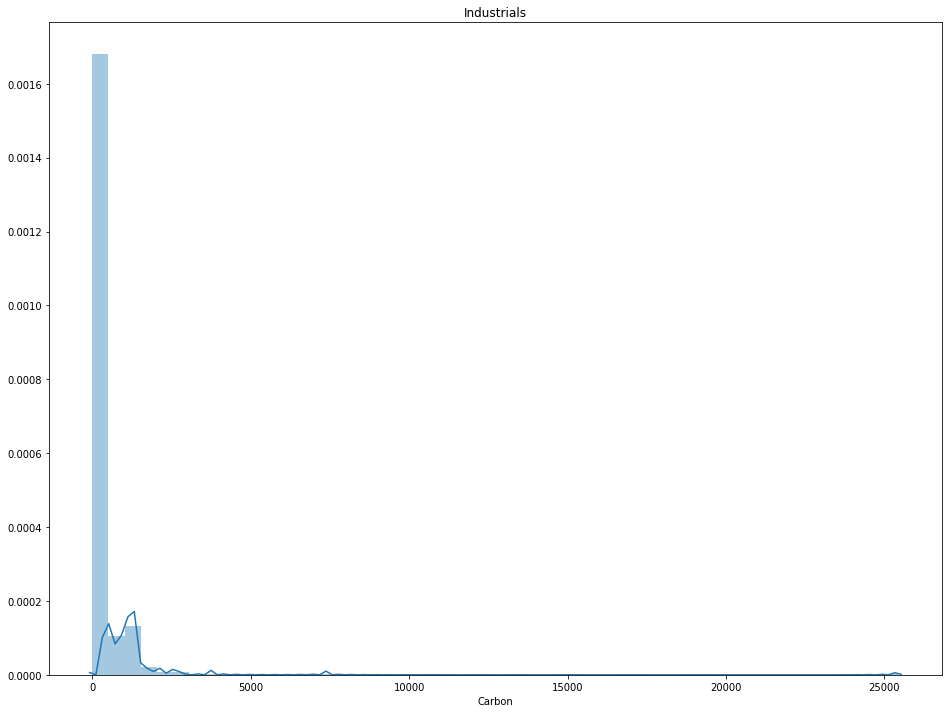

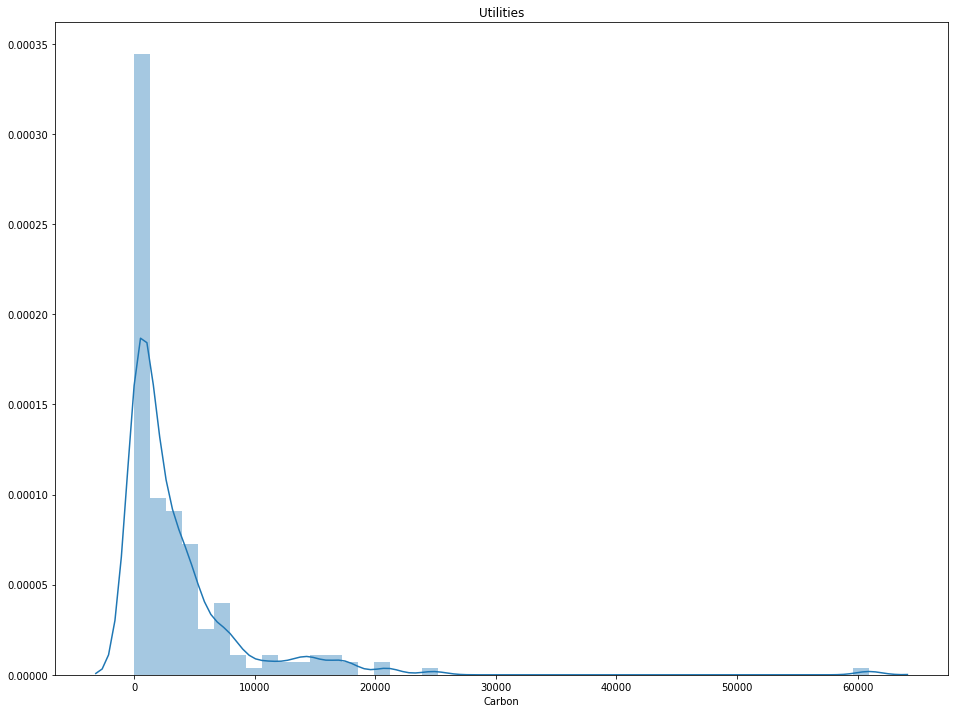

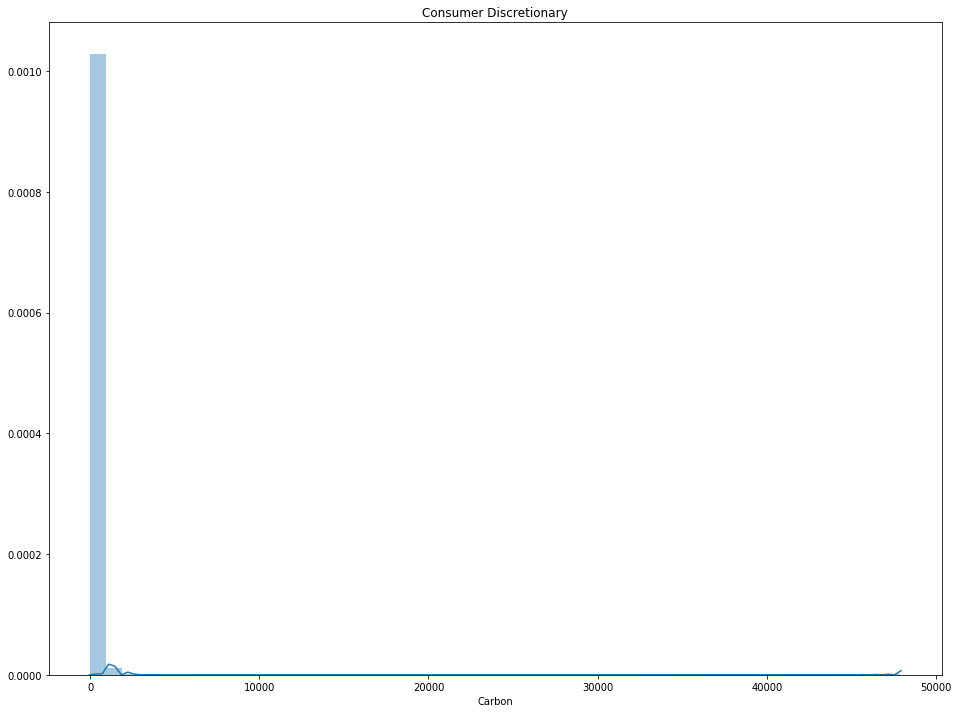

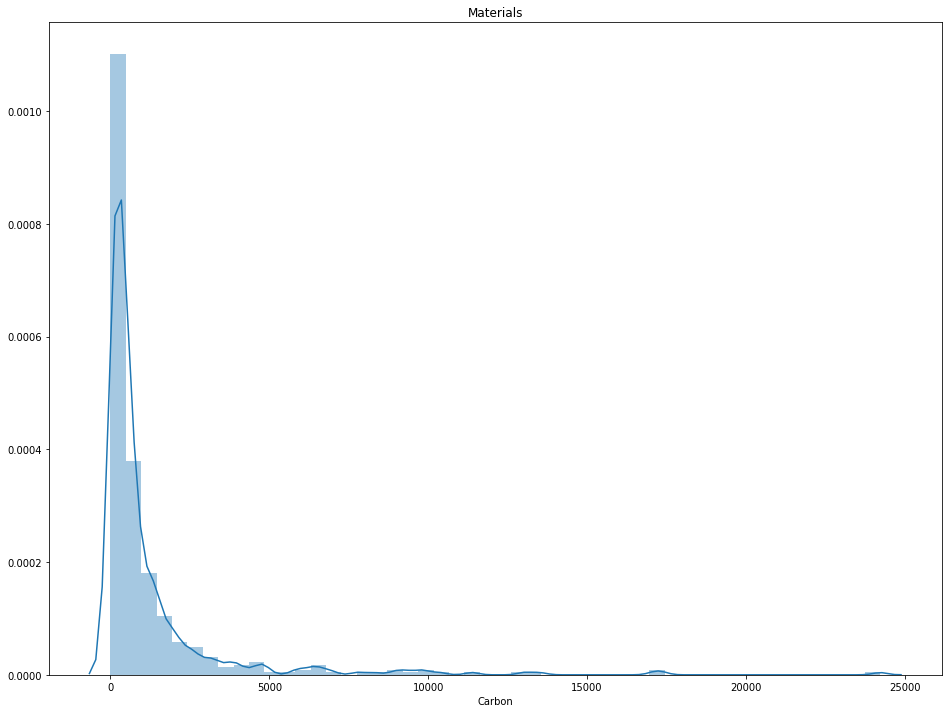

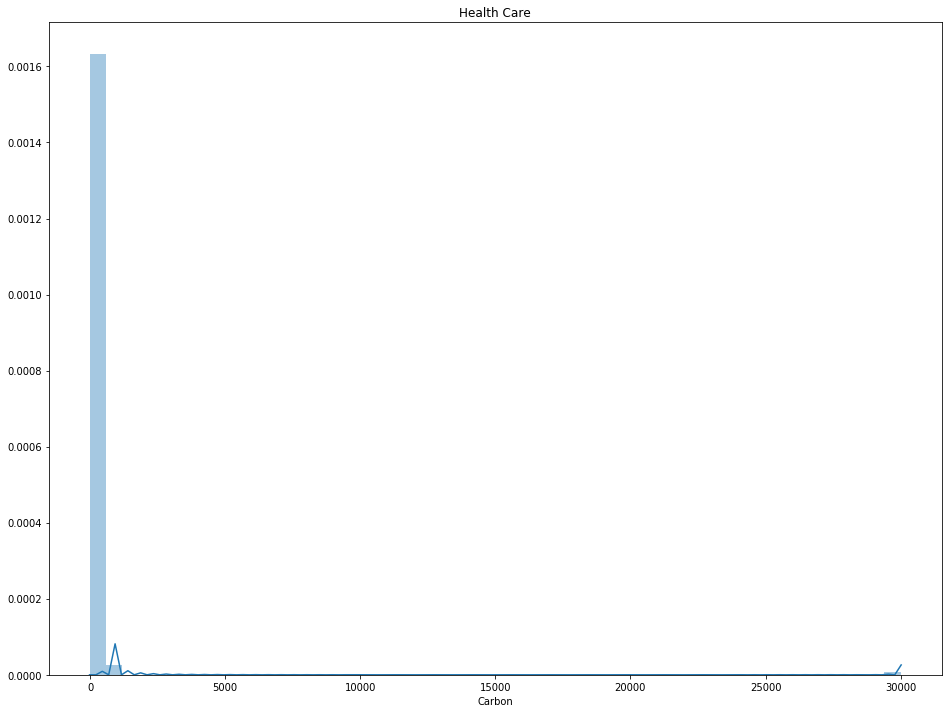

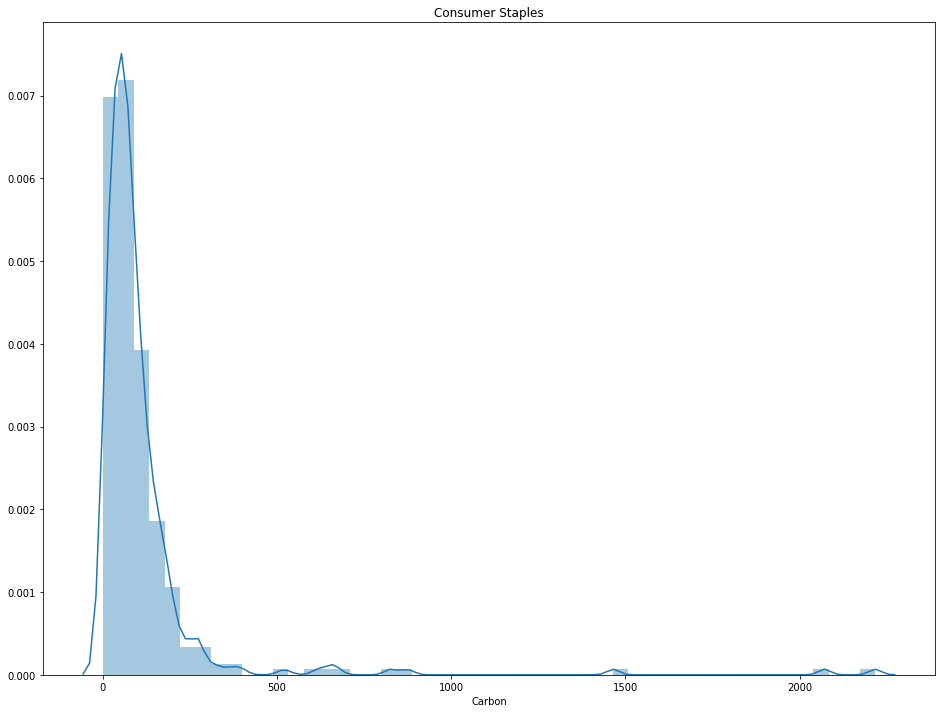

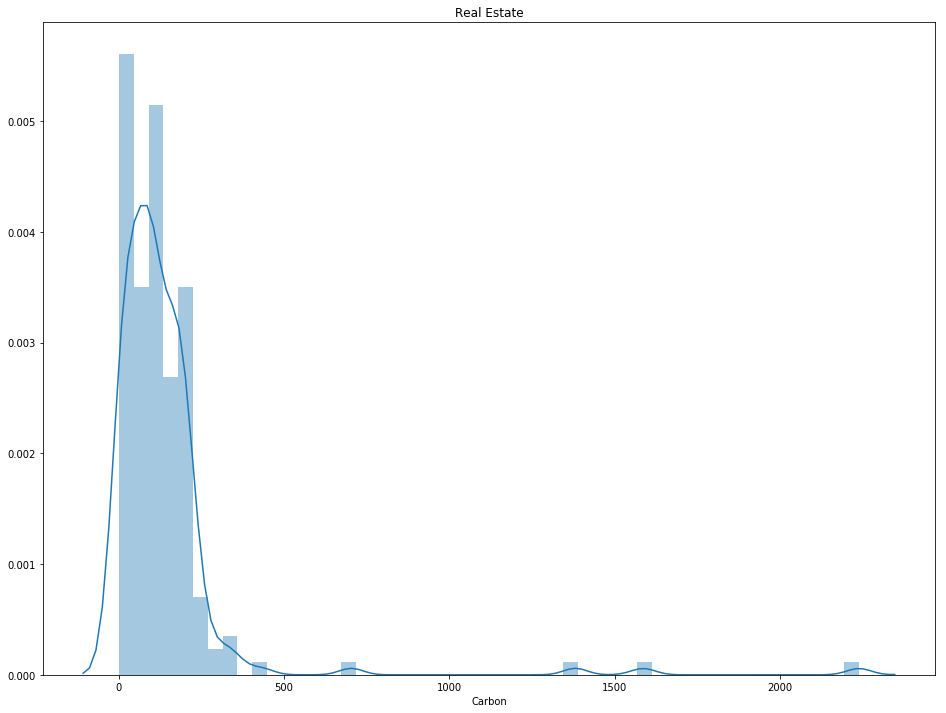

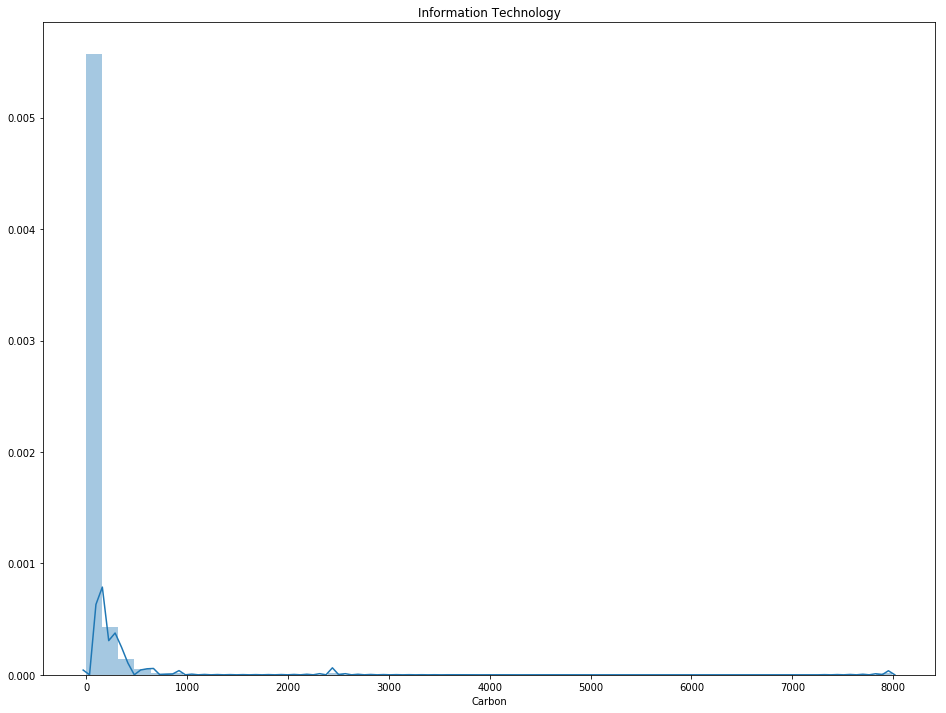

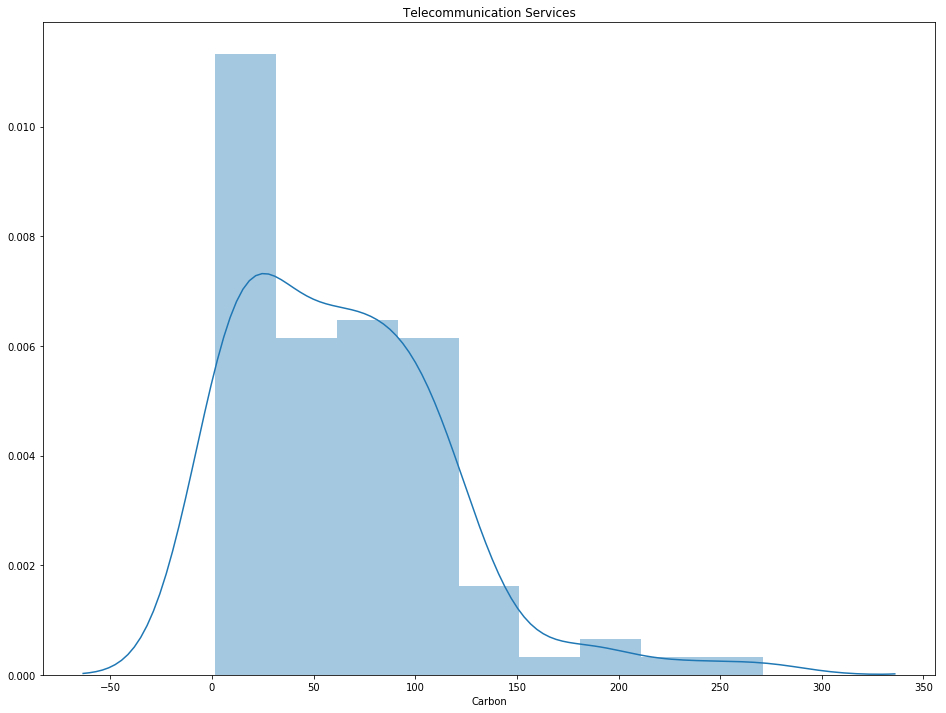

In [23]:
sectors = df['GICS_Sector'].unique()
for sector in sectors: 
    sector_df = df[df['GICS_Sector'] == sector]
    plt.figure(figsize=(16,12))
    plt.title(sector)
    sns.distplot(sector_df.Carbon)
    plt.show()

In [36]:
df['Carbon_ln'] = np.log(df['Carbon'])

/Users/ahilan/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



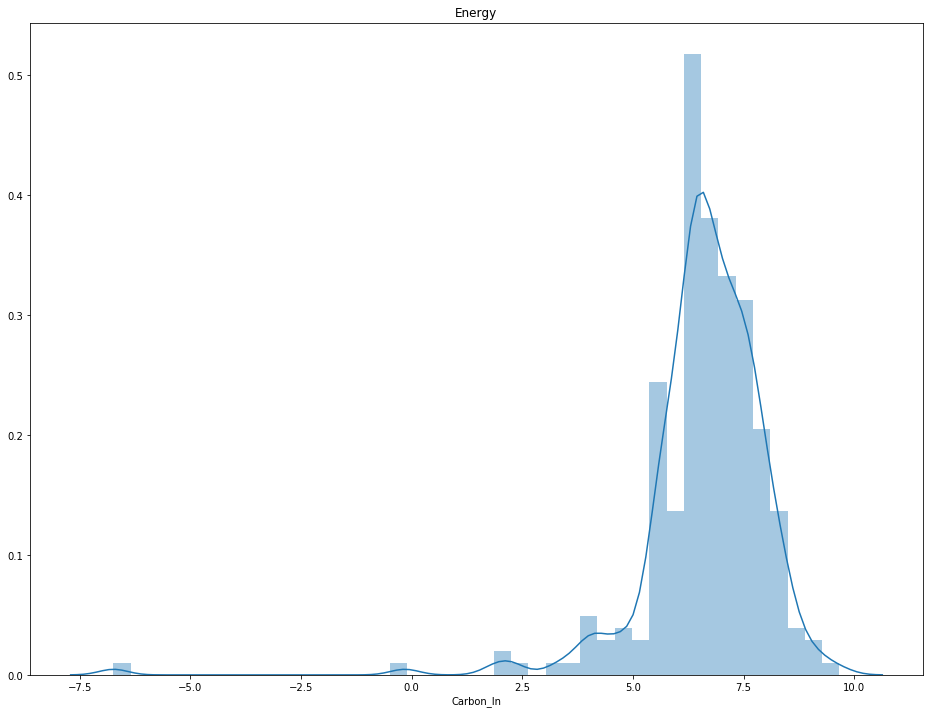

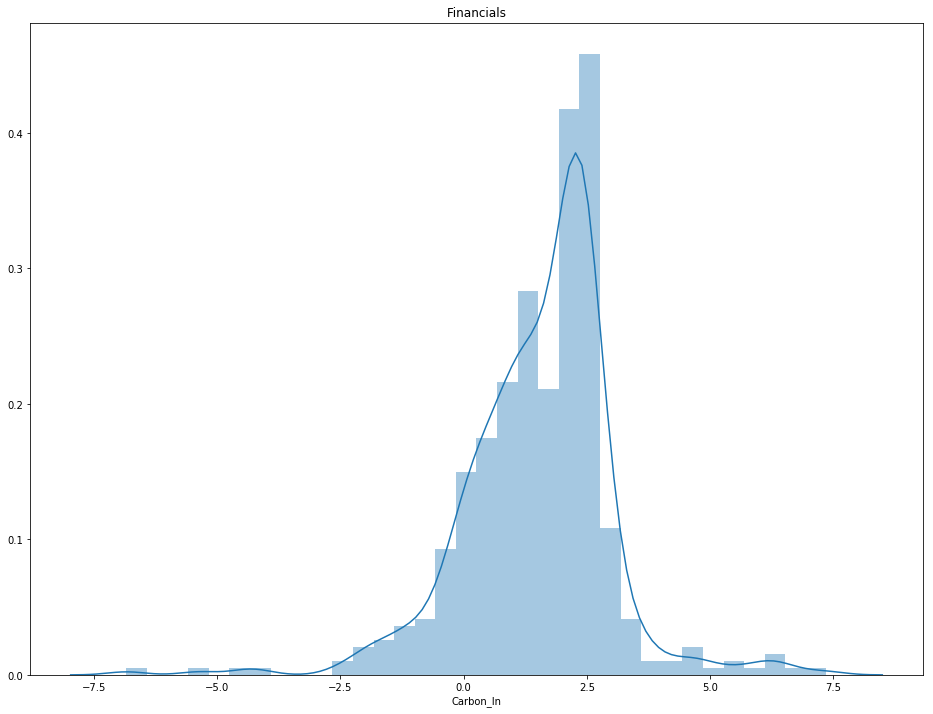

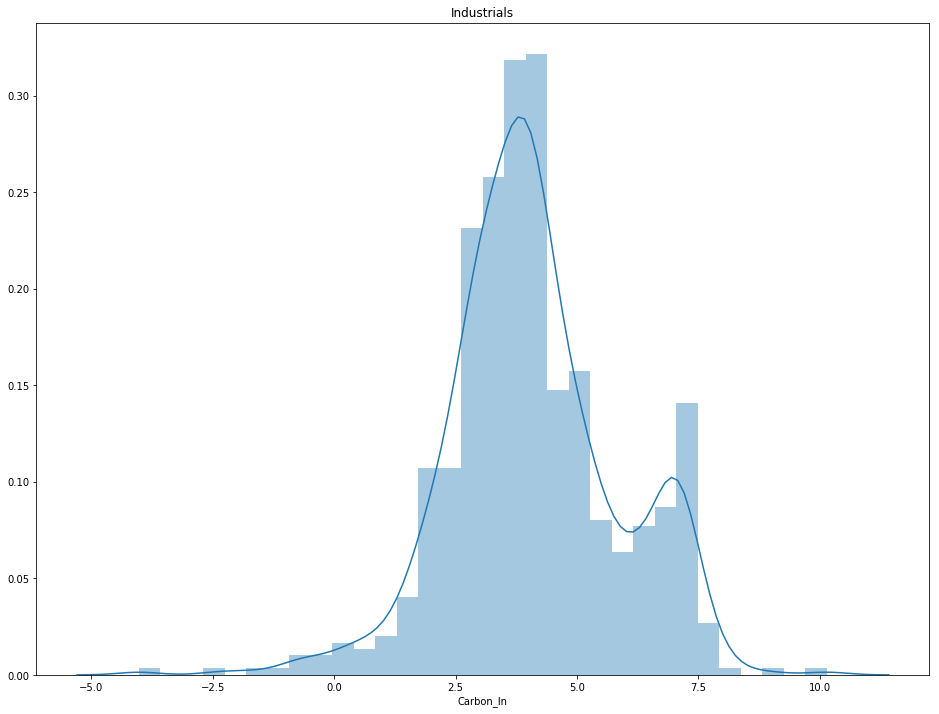

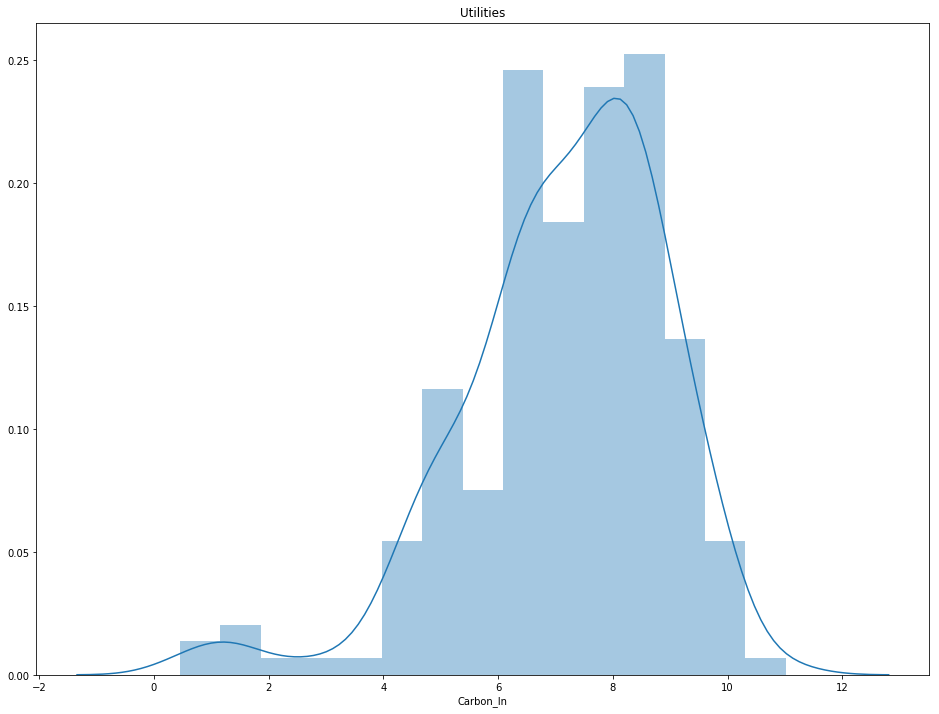

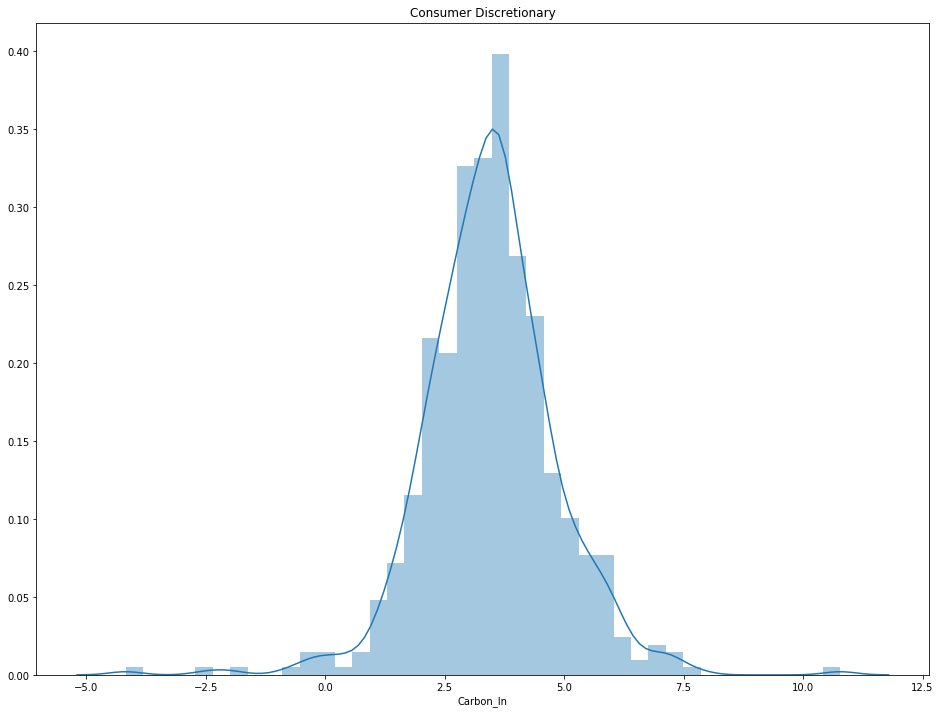

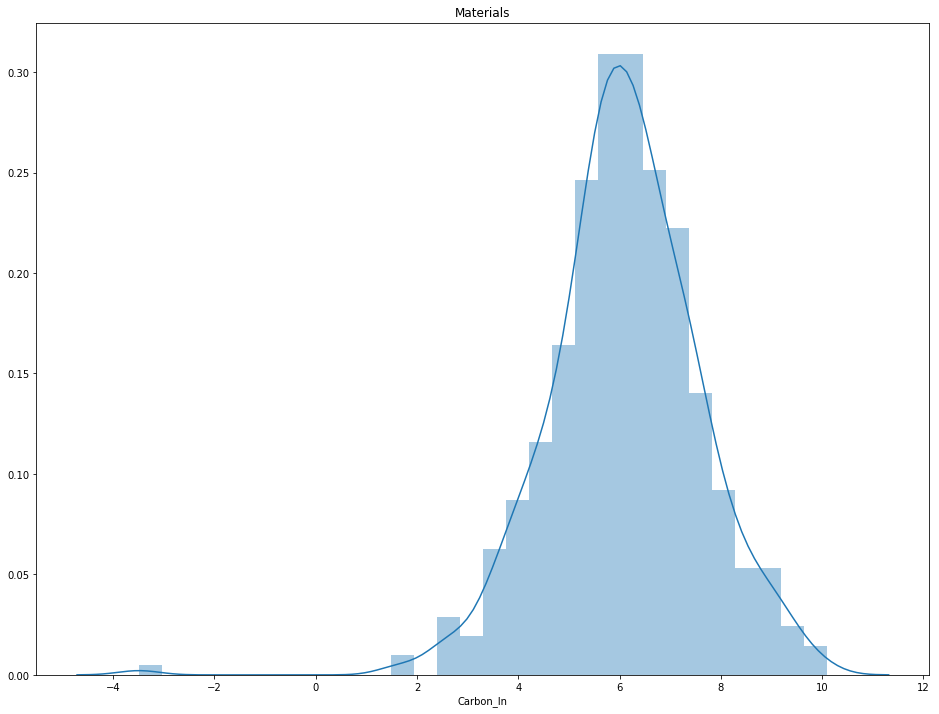

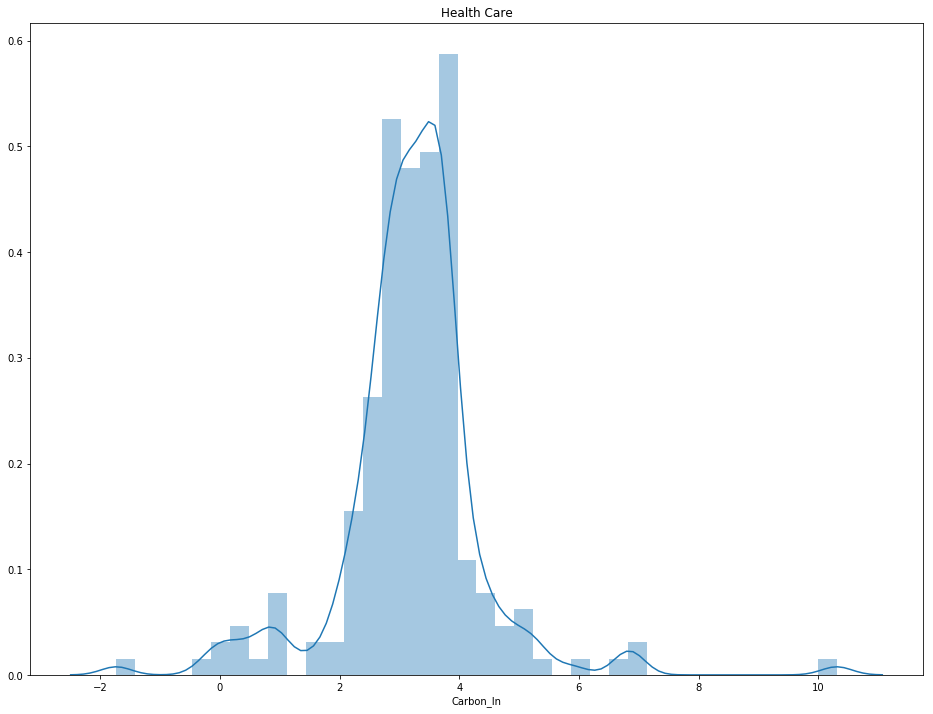

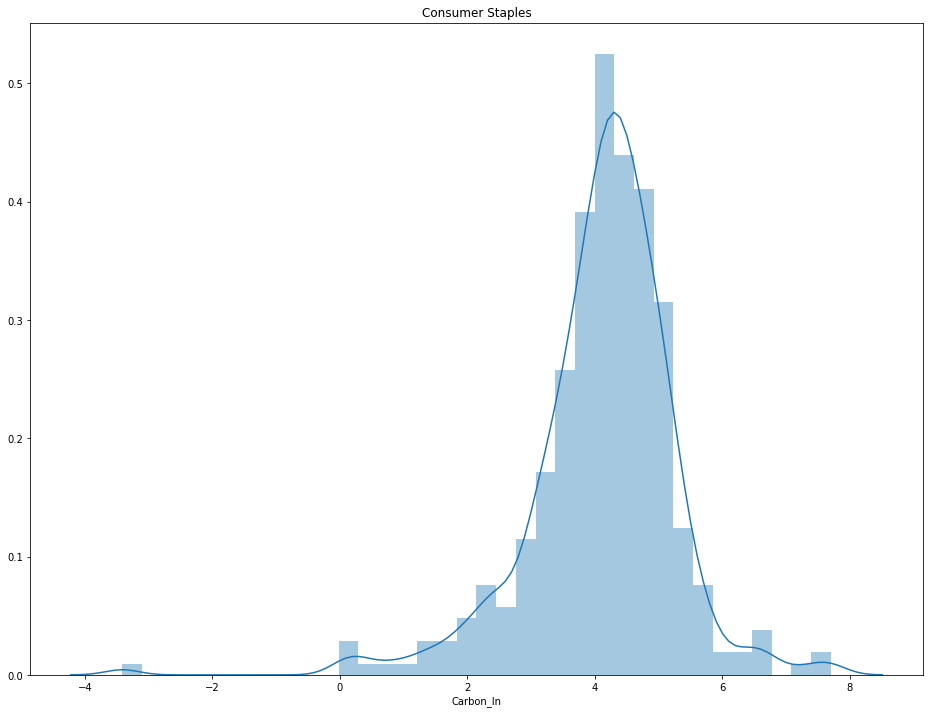

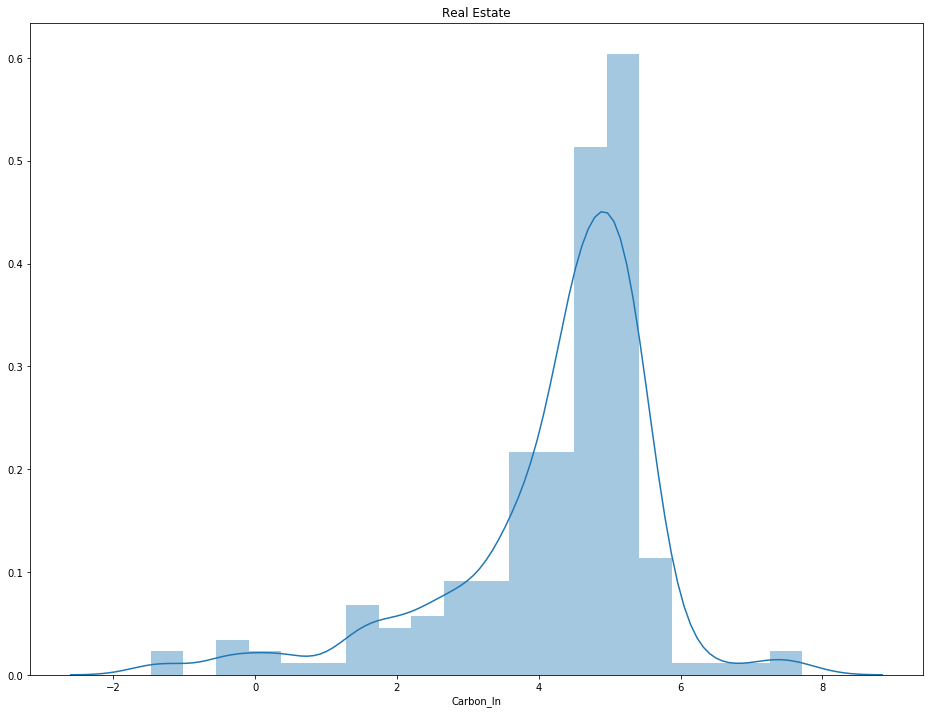

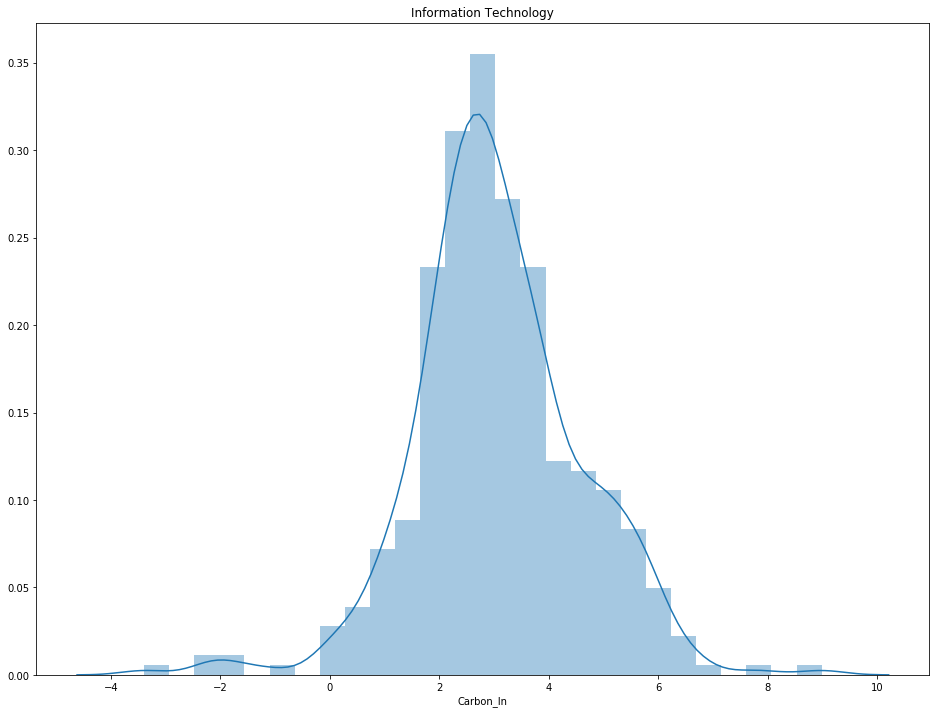

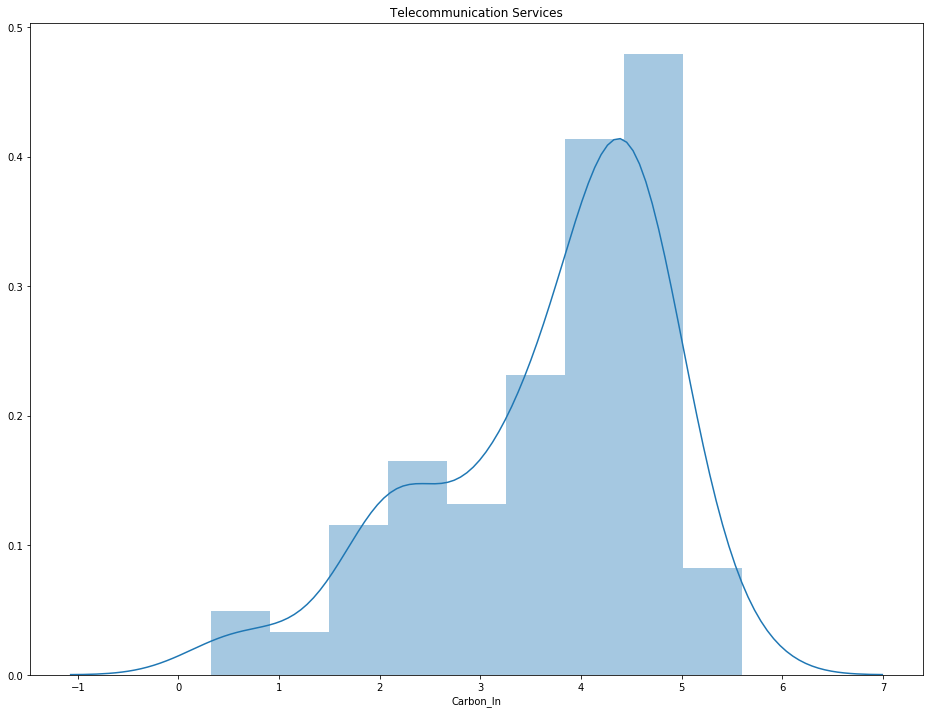

In [37]:
sectors = df['GICS_Sector'].unique()
for sector in sectors: 
    sector_df = df[df['GICS_Sector'] == sector]
    plt.figure(figsize=(16,12))
    plt.title(sector)
    sns.distplot(sector_df.Carbon_ln)
    plt.show()

In [44]:
formula = 'Carbon_ln ~ C(GICS_Sector)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                    df       sum_sq     mean_sq           F  PR(>F)
C(GICS_Sector)    10.0  9293.519200  929.351920  416.263315     0.0
Residual        3856.0  8608.928228    2.232606         NaN     NaN


In [39]:
formula = 'Carbon_ln ~ Energy + Consumer_Discretionary + Industrials + Materials + Consumer_Staples + Financials + Utilities + Telecommunication_Services + Information_Technology + Health_Care'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                 sum_sq      df           F        PR(>F)
Energy                       629.171480     1.0  281.810368  4.258171e-61
Consumer_Discretionary        85.449824     1.0   38.273582  6.790436e-10
Industrials                    2.921166     1.0    1.308411  2.527536e-01
Materials                    465.655917     1.0  208.570587  4.401169e-46
Consumer_Staples               1.734370     1.0    0.776837  3.781653e-01
Financials                   982.113006     1.0  439.895380  1.404018e-92
Utilities                    846.830434     1.0  379.301356  1.177273e-80
Telecommunication_Services    19.669765     1.0    8.810227  3.013896e-03
Information_Technology       175.324512     1.0   78.529092  1.181284e-18
Health_Care                  102.001644     1.0   45.687260  1.595851e-11
Residual                    8608.928228  3856.0         NaN           NaN


In [41]:
x1 = df[['Energy', 'Industrials', 'Materials', 'Utilities']]
y1 = df['Carbon']
X = sm.add_constant(x1)
model_sm = sm.OLS(y1,X)
results = model_sm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Carbon   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     187.5
Date:                Fri, 14 Feb 2020   Prob (F-statistic):          4.42e-147
Time:                        10:31:15   Log-Likelihood:                -34824.
No. Observations:                3867   AIC:                         6.966e+04
Df Residuals:                    3862   BIC:                         6.969e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         108.1494     41.440      2.610      0.009      26.903     189.395
Energy       1260.5437    128.723      9.793      0.000    1008.173    1512.915
Industrials   170.8449     86.549      1.974      0.048       1.159     340.531
Materials    1098.0987    101.154     10.856      0.000     899.778    1296.419
Utilities    3584.7501    142.918     25.083      0.000    3304.549    3864.951
==============================================================================
Omnibus:                     7262.176   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15781144.072
Skew:                          14.003   Prob(JB):                         0.00
Kurtosis:                     314.704   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
hypotheses = '(Energy = Industrials = Materials = Utilities)'
f_test = results.f_test(hypotheses)
print(f_test)

<F test: F=array([[160.17942896]]), p=7.409952058293292e-98, df_denom=3862, df_num=3>


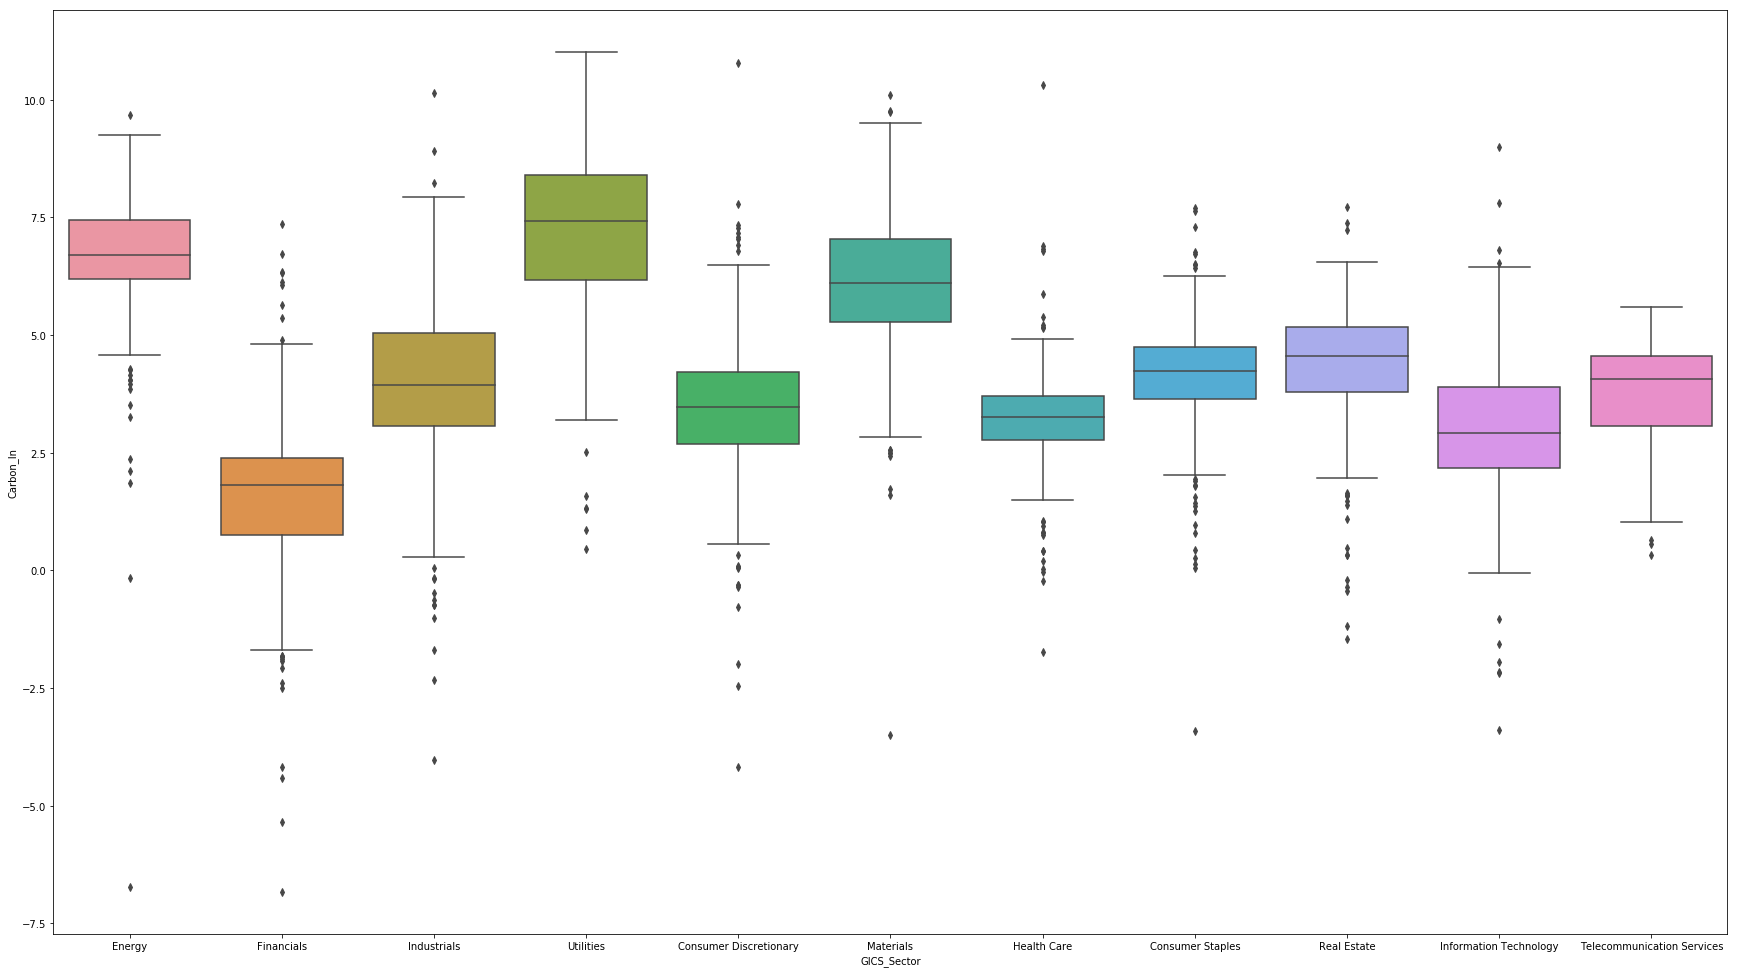

In [42]:
plt.figure(figsize=(30,17))
sns.boxplot(x = df["GICS_Sector"], y = df["Carbon_ln"])

### Hypothesis 2 - Do firms reporting Carbon Emissions as part of thier annual reports produce less emissions than those who do not report emissions?

/Users/ahilan/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



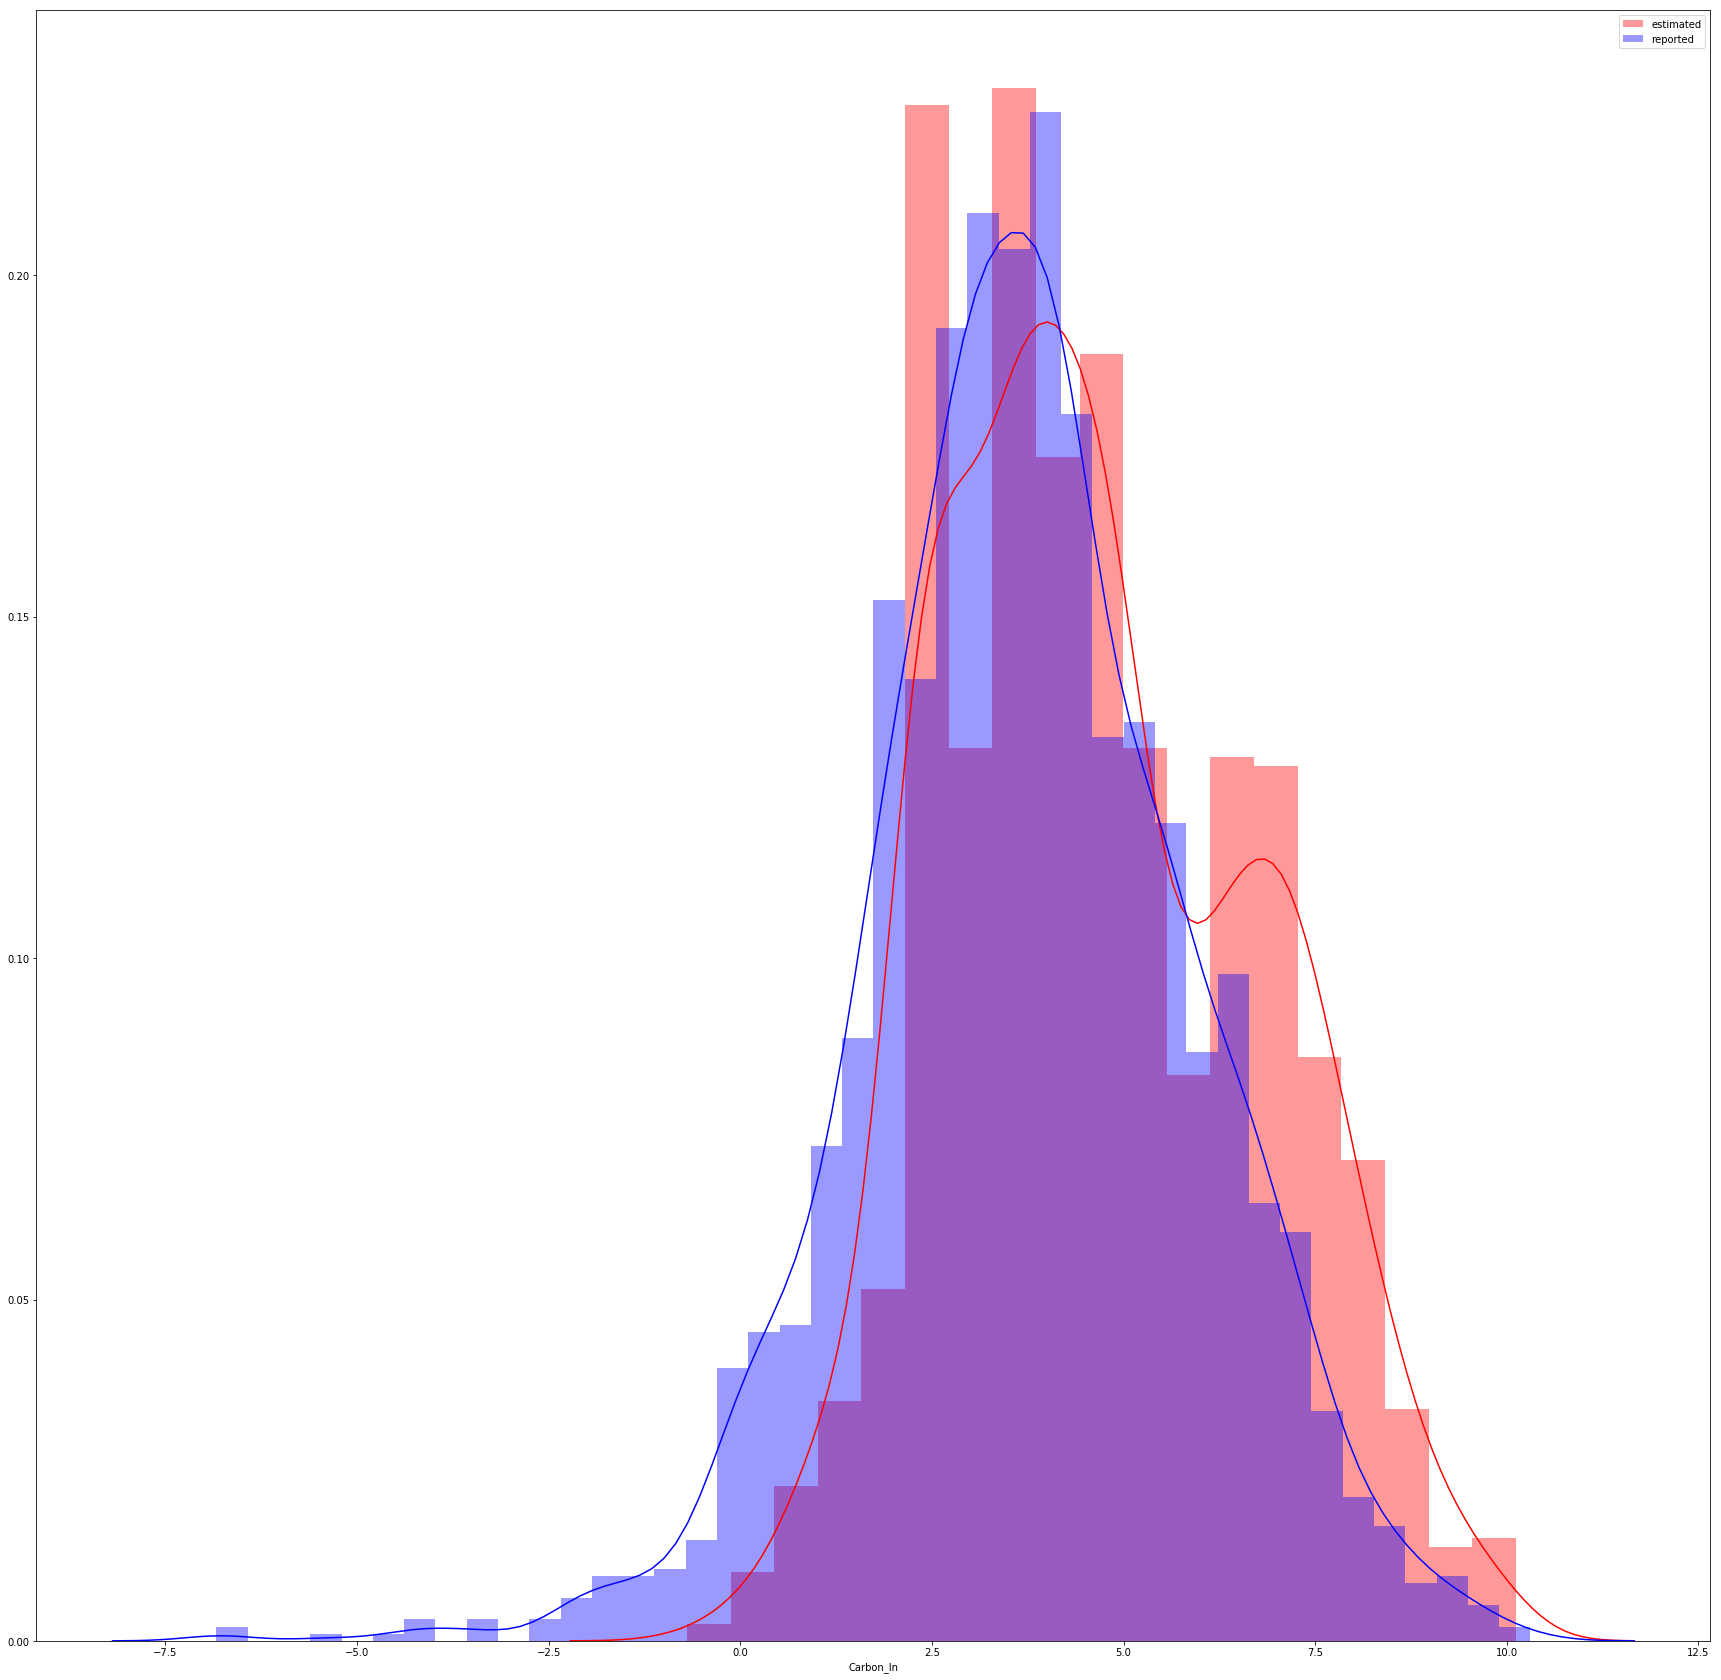

In [50]:
plt.figure(figsize=(30,30))
sns.distplot(df.loc[df['Estimated_or_not']=="Estimated"]["Carbon_ln"],color="r",label="estimated")
sns.distplot(df.loc[df['Estimated_or_not']=="Reported"]["Carbon_ln"],color='b',label='reported')
plt.legend()

In [53]:
ztest ,pval1 = stests.ztest(df.loc[df['Estimated_or_not']=="Estimated"]["Carbon"], x2=df.loc[df['Estimated_or_not']=="Reported"]["Carbon"], value=0,alternative='two-sided')
print(float(pval1))
if pval1<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

2.9442513798977264e-12
reject null hypothesis


### Hypothesis 3 - Is there a relationship between public sentiment and Carbon Emissions

In [56]:
df = df[df.angerindex != 0]

In [57]:
x1 = df[['HE_positiveindex', 'angerindex']]
y1 = df['Carbon']
X = sm.add_constant(x1)
model_sm = sm.OLS(y1,X)
results = model_sm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Carbon   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     28.09
Date:                Fri, 14 Feb 2020   Prob (F-statistic):           1.16e-12
Time:                        11:01:01   Log-Likelihood:                -10737.
No. Observations:                1255   AIC:                         2.148e+04
Df Residuals:                    1252   BIC:                         2.149e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              733.0666    168.307      4.356      0.000     402.873    1063.261
HE_positiveindex    -6.8189      1.206     -5.653      0.000      -9.185      -4.452
angerindex           4.1866      0.964      4.345      0.000       2.296       6.077
==============================================================================
Omnibus:                     1507.526   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           149440.493
Skew:                           6.228   Prob(JB):                         0.00
Kurtosis:                      54.987   Cond. No.                         695.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""